In [2]:
import numpy as np
import matplotlib.pyplot as plt
# %matplotlib widget
import os
from scipy.signal import savgol_filter

In [3]:
folder_out = 'data_out'

(-5.0, 0.0)

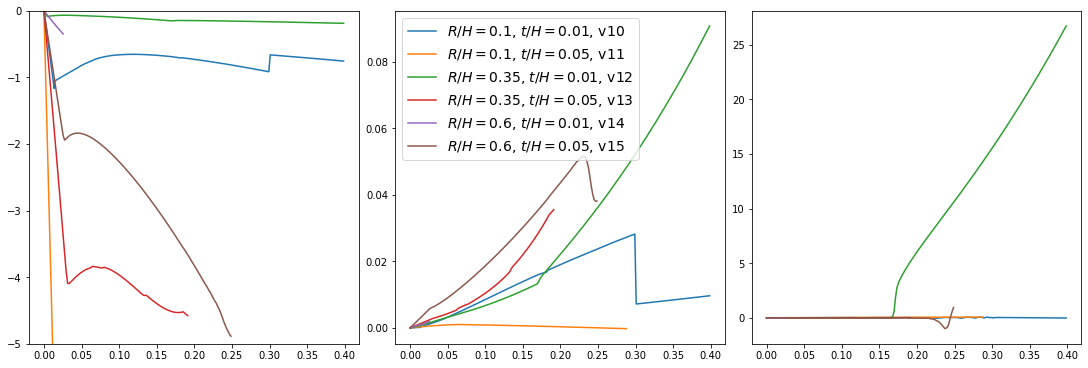

In [17]:
fig, ax = plt.subplots(1,3, figsize = (15,5), constrained_layout = True)
#props:
#[self.H, self.R, self.t1, self.t2, self.theta, self.w, self.E1, self.E2, self.E_cap, self.h_element]
idx_initial = 10
n1 = 3
n2 = 2
v1_sweep = np.linspace(0.1, 0.6, n1)
v2_sweep = np.linspace(0.01, 0.05, n2)

for i, v1 in enumerate(v1_sweep):
    for j, v2 in enumerate(v2_sweep):
        idx_try = idx_initial + i*len(v2_sweep) + j

        proj_name = f'geo_sweep_v{idx_try}'
        cvol, pcav = np.loadtxt(f'{folder_out}/{proj_name}_pcav_cvol.txt', unpack = True)
        time, contraction, twist = np.loadtxt(f'{folder_out}/{proj_name}_contraction_twist.txt', unpack = True)

        vol_norm = -(cvol - cvol[0]) / cvol[0]
        p_kpa = pcav * 1e3
        contraction_strain = 1 - contraction
        twist_deg = twist * 180 / np.pi

        ax[0].plot(vol_norm, p_kpa)
        ax[1].plot(vol_norm, contraction_strain, label = f'$R/H = {v1}$, $t/H = {v2}$, v{idx_try}')
        ax[2].plot(vol_norm, twist_deg)
    
ax[1].legend(loc = 'best', fontsize = 14)
ax[0].set_ylim(top = 0, bottom = -5)
            